In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import ddsp
from ddsp.training import (
    train_util,
    trainers,
    data,
)

from src.data.dataset import get_provider
from src.evaluation.utils import (
    save_wav,
    draw_wave,
    draw_spect,
)
from src.models.ddsp_models import get_trainer

import IPython.display as ipd

2021-11-05 17:21:07.812906: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-05 17:21:07.813033: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# copied over from the appropriate config
SAMPLE_RATE = 16000
EXAMPLE_SECS = 2
FRAME_RATE = 250
TIME_STEPS = FRAME_RATE * EXAMPLE_SECS
N_SAMPLES = SAMPLE_RATE * EXAMPLE_SECS
# CHCKPT = '2021-10-29/iaf_snares_20-00-04'
CHCKPT = '2021-11-05/test_19-05-01'
DS = 'snares_small.tfrecord'
STRAT = train_util.get_strategy()

2021-11-05 17:21:13.625320: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-05 17:21:13.626335: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-05 17:21:13.626366: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-05 17:21:13.626395: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayylmao): /proc/driver/nvidia/version does not exist
2021-11-05 17:21:13.630083: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropr

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [3]:
ds_prov = get_provider(DS, EXAMPLE_SECS, SAMPLE_RATE, FRAME_RATE)
ds = ds_prov.get_dataset(shuffle=True)
ds_iter = iter(ds)

2021-11-05 17:21:18.151038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-05 17:21:18.168642: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2700905000 Hz


In [4]:
ex0 = next(ds_iter)
ipd.Audio(ex0['audio'].numpy(), rate=SAMPLE_RATE)

In [5]:
trainer = get_trainer(model_name="gauss_vae", time_steps=TIME_STEPS, sample_rate=SAMPLE_RATE, n_samples=N_SAMPLES, restore_checkpoint=CHCKPT, kl_weight=1)
model = trainer.model
model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [6]:
# with train_util.get_strategy().scope():
#     output = model(ex0, training=False)

# output = model(ex0, training=False)

In [7]:
# audio = ex0['audio']
# audio_gen = np.array(model.get_audio_from_outputs(output))

In [8]:
# ipd.Audio(audio, rate=SAMPLE_RATE)

In [9]:
# ipd.Audio(audio_gen, rate=SAMPLE_RATE)

In [10]:
ds_batch = ds_prov.get_batch(batch_size=32, shuffle=False)
ds_batch

<PrefetchDataset shapes: {audio: (32, 32000), f0_confidence: (32, 500), f0_hz: (32, 500), loudness_db: (32, 500)}, types: {audio: tf.float32, f0_confidence: tf.float32, f0_hz: tf.float32, loudness_db: tf.float32}>

In [11]:
ds_batch_iter = iter(ds_batch)

In [12]:
scope_initialized = False

In [13]:
batch_1 = next(ds_batch_iter)

if not scope_initialized:
    with train_util.get_strategy().scope():
        batch_outs = model(batch_1, training=False)
    scope_initialized = True
else:
    batch_outs = model(batch_1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
2021-11-05 17:21:34.318623: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 184320000 exceeds 10% of free system memory.
2021-11-05 17:21:34.470597: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 369377280 exceeds 10% of free system memory.
2021-11-05 17:21:34.649685: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 370851840 exceeds 10% of free system memory.
2021-11-05 17:21:34.799810: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 370851840 exceeds 10% of free system memory.
2021-11-05 17:21:35.020475: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 370114560 exceeds 10% of free system memory.


In [14]:
batch_audio = batch_1['audio']
batch_audio_gens = model.get_audio_from_outputs(batch_outs)

In [29]:
# i = np.random.randint(batch_audio.numpy().shape[0])
i = 25
i

25

In [31]:
ipd.Audio(batch_audio.numpy()[i], rate=SAMPLE_RATE)

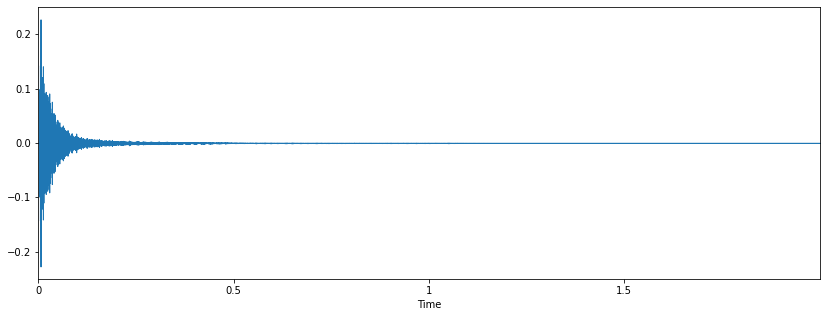

In [32]:
draw_wave(batch_audio.numpy()[i], sr=SAMPLE_RATE)

In [33]:
# note: this is played normalized by ipython

ipd.Audio(batch_audio_gens.numpy()[i], rate=SAMPLE_RATE)

In [19]:
# save_wav(f'generated/{CHCKPT}01.wav', batch_audio_gens.numpy()[i], sr=SAMPLE_RATE)

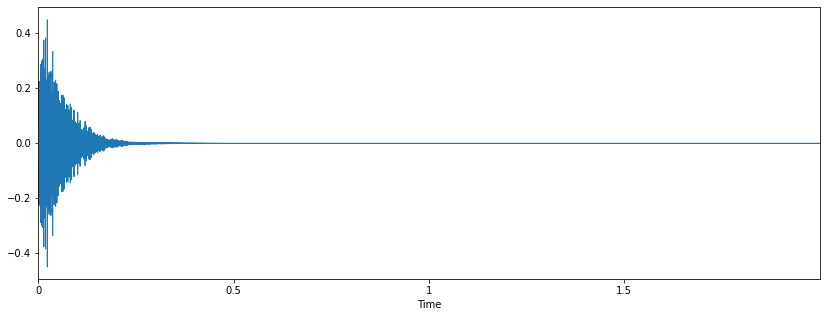

In [20]:
draw_wave(batch_audio_gens.numpy()[i], sr=SAMPLE_RATE)

In [ ]:
# oh fuck this works - try feeding in random z's to the decoder lol

In [21]:
list(batch_outs.keys())

['inputs',
 'audio',
 'f0_confidence',
 'f0_hz',
 'loudness_db',
 'f0_scaled',
 'ld_scaled',
 'z',
 'logq',
 'logp',
 'amps',
 'harmonic_distribution',
 'noise_magnitudes',
 'harmonic',
 'noise',
 'add',
 'out',
 'audio_synth']

In [22]:
batch_outs['z'][i]

<tf.Tensor: shape=(500, 32), dtype=float32, numpy=
array([[-0.7361971, -1.7293881, -1.1106379, ...,  2.1233888, -1.4062372,
         0.3003337],
       [-0.7361971, -1.7293881, -1.1106379, ...,  2.1233888, -1.4062372,
         0.3003337],
       [-0.7361971, -1.7293881, -1.1106379, ...,  2.1233888, -1.4062372,
         0.3003337],
       ...,
       [-0.7361971, -1.7293881, -1.1106379, ...,  2.1233888, -1.4062372,
         0.3003337],
       [-0.7361971, -1.7293881, -1.1106379, ...,  2.1233888, -1.4062372,
         0.3003337],
       [-0.7361971, -1.7293881, -1.1106379, ...,  2.1233888, -1.4062372,
         0.3003337]], dtype=float32)>

In [34]:
# some_z = tf.random.uniform([32, 500, 32], minval=-1, maxval=1)
some_z = tf.random.normal([32, 500, 32])

In [35]:
def call_only_decoder(model, input_z, batch_outs):
    features = {}
    features['f0_hz'] = batch_outs['f0_hz']
    features['loudness_db'] = batch_outs['loudness_db']
    features['audio'] = batch_outs['audio']
    features = model.encode(features, training=False)
    features['z'] = input_z
    features.update(model.decoder(features, training=False))

    # Run through processor group.
    pg_out = model.processor_group(features, return_outputs_dict=True)

    # Parse outputs
    outputs = pg_out['controls']
    outputs['audio_synth'] = pg_out['signal']
    
    return outputs

In [36]:
some_z_outputs = call_only_decoder(model, some_z, batch_outs)

In [38]:
some_z_audio = some_z_outputs['audio']
some_z_audio_gen = some_z_outputs['audio_synth']
# i = np.random.randint(batch_audio.numpy().shape[0])
i = 25
i

25

In [40]:
ipd.Audio(some_z_audio.numpy()[i], rate=SAMPLE_RATE)

In [41]:
ipd.Audio(some_z_audio_gen.numpy()[i], rate=SAMPLE_RATE)

# Controls breakdown

In [ ]:
print(model.preprocessor.all_input_keys, model.encoder.all_input_keys)

In [ ]:
import ddsp

In [ ]:
batch_idx = 0
get = lambda key: ddsp.core.nested_lookup(key, batch_outs)[batch_idx]

amps = get('harmonic/controls/amplitudes')
harmonic_distribution = get('harmonic/controls/harmonic_distribution')
noise_magnitudes = get('noise/controls/magnitudes')
f0_hz = get('f0_hz')
loudness = get('loudness_db')

audio_noise = get('noise/signal')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Input Features', fontsize=16)
ax[0].plot(loudness)
ax[0].set_ylabel('Loudness')
ax[1].plot(f0_hz)
ax[1].set_ylabel('F0_Hz')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Synth Params', fontsize=16)
ax[0].semilogy(amps)
ax[0].set_ylabel('Amps')
ax[0].set_ylim(1e-5, 2)
# ax[0].semilogy(harmonic_distribution)
ax[1].matshow(np.rot90(np.log10(harmonic_distribution + 1e-6)),
              cmap=plt.cm.magma, 
              aspect='auto')
ax[1].set_ylabel('Harmonic Distribution')
ax[1].set_xticks([])
_ = ax[1].set_yticks([])

f, ax = plt.subplots(1, 1, figsize=(7, 4))
# f.suptitle('Filtered Noise Params', fontsize=16)
ax.matshow(np.rot90(np.log10(noise_magnitudes + 1e-6)), 
           cmap=plt.cm.magma, 
           aspect='auto')
ax.set_ylabel('Filtered Noise Magnitudes')
ax.set_xticks([])
_ = ax.set_yticks([])